In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
### Root Mean Squared Log Error function for GridSearch 
def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train = train.fillna(-1)

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,57.445890,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.111644,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,34.960241,9981.264932,1.382997,1.112799,30.202904,20.645407,180.734517,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,-1.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
cats = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 
        'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir',
        'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'Fence', 
        'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 
        'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 
        'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 
        'LandSlope', 'LotConfig', 'LotShape', 'MasVnrType', 
        'MiscFeature', 'MoSold', 'MSSubClass', 'MSZoning', 
        'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
        'SaleCondition', 'SaleType', 'Street', 'Utilities']
nums = ['GarageYrBlt', 'LotFrontage', 'MasVnrArea', '1stFlrSF', 
        '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 
        'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 
        'GarageArea', 'GarageCars', 'GrLivArea', 'HalfBath', 
        'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MiscVal', 
        'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 
        'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 
        'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']

In [6]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer().fit(train[cats].T.to_dict().values())
cat_matrix = dv.transform(train[cats].T.to_dict().values())

In [ ]:
print dv.get_feature_names()

In [7]:
data_matrix = hstack([cat_matrix, train[nums]])

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly_matrix = poly.fit_transform(data_matrix.toarray())

In [76]:
X_train, X_test, y_train, y_test = train_test_split(poly_matrix, train['SalePrice'], test_size=0.33, random_state=42)

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor()
n_estimators = [50, 100, 300, 400]
max_depth = [2, 4, 5, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
tuned_parameters = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
grid = GridSearchCV(boost, tuned_parameters, cv=5, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] n_estimators=50, learning_rate=0.0001, max_depth=2 ..............
[CV] n_estimators=50, learning_rate=0.0001, max_depth=2 ..............
[CV] n_estimators=50, learning_rate=0.0001, max_depth=2 ..............
[CV] n_estimators=50, learning_rate=0.0001, max_depth=2 ..............
[CV]  n_estimators=50, learning_rate=0.0001, max_depth=2, score=-40228016413.5, total=  50.6s
[CV] n_estimators=50, learning_rate=0.0001, max_depth=2 ..............
[CV]  n_estimators=50, learning_rate=0.0001, max_depth=2, score=-37806153644.9, total=  50.8s
[CV] n_estimators=100, learning_rate=0.0001, max_depth=2 .............
[CV]  n_estimators=50, learning_rate=0.0001, max_depth=2, score=-38403119290.1, total=  50.9s
[CV] n_estimators=100, learning_rate=0.0001, max_depth=2 .............
[CV]  n_estimators=50, learning_rate=0.0001, max_depth=2, score=-36615849913.2, total=  50.9s
[CV] n_estimators=100, learning_rate=0.0001, max_depth=2 ........

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 17.7min


[CV]  n_estimators=400, learning_rate=0.0001, max_depth=2, score=-35644773761.1, total= 5.7min
[CV] n_estimators=100, learning_rate=0.0001, max_depth=4 .............
[CV]  n_estimators=100, learning_rate=0.0001, max_depth=4, score=-39833890756.9, total= 2.7min
[CV] n_estimators=100, learning_rate=0.0001, max_depth=4 .............
[CV]  n_estimators=100, learning_rate=0.0001, max_depth=4, score=-37448301891.0, total= 2.7min
[CV] n_estimators=300, learning_rate=0.0001, max_depth=4 .............
[CV]  n_estimators=100, learning_rate=0.0001, max_depth=4, score=-38050906341.3, total= 2.7min
[CV] n_estimators=300, learning_rate=0.0001, max_depth=4 .............
[CV]  n_estimators=100, learning_rate=0.0001, max_depth=4, score=-36267796548.9, total= 2.7min
[CV] n_estimators=300, learning_rate=0.0001, max_depth=4 .............
[CV]  n_estimators=100, learning_rate=0.0001, max_depth=4, score=-37629691398.7, total= 2.7min
[CV] n_estimators=300, learning_rate=0.0001, max_depth=4 .............
[CV]

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 179.9min


[CV]  n_estimators=50, learning_rate=0.001, max_depth=4, score=-34694153739.1, total= 1.4min
[CV] n_estimators=50, learning_rate=0.001, max_depth=4 ...............
[CV]  n_estimators=50, learning_rate=0.001, max_depth=4, score=-35394722971.4, total= 1.4min
[CV] n_estimators=100, learning_rate=0.001, max_depth=4 ..............
[CV]  n_estimators=50, learning_rate=0.001, max_depth=4, score=-33608457553.6, total= 1.4min
[CV] n_estimators=100, learning_rate=0.001, max_depth=4 ..............
[CV]  n_estimators=50, learning_rate=0.001, max_depth=4, score=-34867338656.3, total= 1.4min
[CV] n_estimators=100, learning_rate=0.001, max_depth=4 ..............
[CV]  n_estimators=100, learning_rate=0.001, max_depth=4, score=-33421218649.5, total= 2.7min
[CV] n_estimators=100, learning_rate=0.001, max_depth=4 ..............
[CV]  n_estimators=100, learning_rate=0.001, max_depth=4, score=-31545991293.3, total= 2.7min
[CV] n_estimators=100, learning_rate=0.001, max_depth=4 ..............
[CV]  n_estima

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 450.4min


[CV]  n_estimators=50, learning_rate=0.01, max_depth=8, score=-16167434936.1, total= 2.1min
[CV] n_estimators=50, learning_rate=0.01, max_depth=8 ................
[CV]  n_estimators=50, learning_rate=0.01, max_depth=8, score=-14549716640.7, total= 2.3min
[CV] n_estimators=100, learning_rate=0.01, max_depth=8 ...............
[CV]  n_estimators=50, learning_rate=0.01, max_depth=8, score=-14837931611.4, total= 2.2min
[CV] n_estimators=100, learning_rate=0.01, max_depth=8 ...............
[CV]  n_estimators=100, learning_rate=0.01, max_depth=8, score=-6139421754.29, total= 4.7min
[CV] n_estimators=100, learning_rate=0.01, max_depth=8 ...............
[CV]  n_estimators=400, learning_rate=0.01, max_depth=6, score=-577336727.32, total=16.0min
[CV] n_estimators=100, learning_rate=0.01, max_depth=8 ...............
[CV]  n_estimators=100, learning_rate=0.01, max_depth=8, score=-6304310492.99, total= 4.7min
[CV] n_estimators=100, learning_rate=0.01, max_depth=8 ...............
[CV]  n_estimators=1

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 687.5min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value)) 
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
# plt.errorbar(max_depth, means, yerr=stds) 

In [ ]:
# plot
scores = np.array(means).reshape(len(max_depth), len(learning_rate))
for i, value in enumerate(learning_rate):
    plt.plot(max_depth, scores[i], label='depth: ' + str(value)) 
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
# plt.errorbar(max_depth, means, yerr=stds) 

In [68]:
%%time
boost = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)
boost = boost.fit(poly_matrix, train['SalePrice'])

CPU times: user 6min 50s, sys: 2.47 s, total: 6min 52s
Wall time: 6min 54s


In [69]:
train_preds = boost.predict(poly_matrix)

In [70]:
from sklearn.metrics import mean_squared_log_error
print mean_squared_log_error(train['SalePrice'], train_preds)**0.5

8591.9330349


In [54]:
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=400, max_depth=2)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
tuned_parameters = dict(learning_rate=learning_rate)
grid = GridSearchCV(boost, tuned_parameters, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid.fit(poly_matrix, train['SalePrice'])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] learning_rate=0.0001 ............................................
[CV] ....... learning_rate=0.0001, score=-32485996371.5, total= 9.6min
[CV] learning_rate=0.0001 ............................................
[CV] ....... learning_rate=0.0001, score=-36836732259.4, total= 9.6min
[CV] learning_rate=0.0001 ............................................
[CV] ....... learning_rate=0.0001, score=-38967337288.7, total= 9.7min
[CV] learning_rate=0.0001 ............................................
[CV] ....... learning_rate=0.0001, score=-37347834241.5, total= 9.6min
[CV] learning_rate=0.0001 ............................................
[CV] ....... learning_rate=0.0001, score=-40917270516.3, total= 9.4min
[CV] learning_ra

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 58.3min


[CV] ......... learning_rate=0.01, score=-1276183632.37, total=10.0min
[CV] learning_rate=0.01 ..............................................
[CV] ......... learning_rate=0.01, score=-863692338.276, total=10.0min
[CV] learning_rate=0.01 ..............................................
[CV] ......... learning_rate=0.01, score=-596091584.296, total=10.0min
[CV] learning_rate=0.1 ...............................................
[CV] ......... learning_rate=0.01, score=-570078150.175, total=10.0min
[CV] learning_rate=0.1 ...............................................
[CV] ......... learning_rate=0.01, score=-1715300120.06, total=10.2min
[CV] learning_rate=0.1 ...............................................
[CV] .......... learning_rate=0.1, score=-488274291.653, total=10.1min
[CV] learning_rate=0.1 ...............................................
[CV] .......... learning_rate=0.1, score=-564040181.189, total=10.1min
[CV] learning_rate=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 149.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

Best: -665929268.522792 using {'learning_rate': 0.1}
-36210197204.407700 (3219724206.763080) with: {'learning_rate': 0.0001}
-18656479952.250378 (2137219891.974844) with: {'learning_rate': 0.001}
-915917160.801793 (383388750.093211) with: {'learning_rate': 0.01}
-665929268.522792 (252279340.069135) with: {'learning_rate': 0.1}
-724385692.956501 (287953075.977521) with: {'learning_rate': 0.2}
-782231868.361170 (334702225.568136) with: {'learning_rate': 0.3}


//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


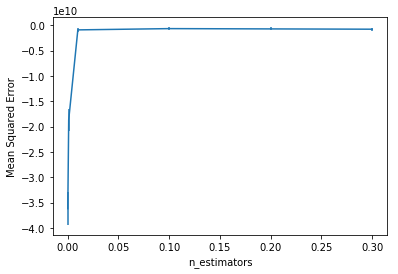

In [55]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
# plt.errorbar(max_depth, means, yerr=stds) 

In [64]:
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(max_depth=2)
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
tuned_parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators)
grid = GridSearchCV(boost, tuned_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid.fit(poly_matrix, train['SalePrice'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=100, learning_rate=0.0001 ..........................
[CV] n_estimators=100, learning_rate=0.0001 ..........................
[CV] n_estimators=100, learning_rate=0.0001 ..........................
[CV] n_estimators=100, learning_rate=0.0001 ..........................
[CV]  n_estimators=100, learning_rate=0.0001, score=-37852704638.9, total= 2.3min
[CV] n_estimators=100, learning_rate=0.0001 ..........................
[CV]  n_estimators=100, learning_rate=0.0001, score=-39288073378.9, total= 2.3min
[CV] n_estimators=200, learning_rate=0.0001 ..........................
[CV]  n_estimators=100, learning_rate=0.0001, score=-40905674663.0, total= 2.3min
[CV] n_estimators=200, learning_rate=0.0001 ..........................
[CV]  n_estimators=100, learning_rate=0.0001, score=-34343745428.2, total= 2.3min
[CV] n_estimators=200, learning_rate=0.0001 ..........................
[CV]  n_estimators=100, learning_rate=0.00

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 38.4min


[CV]  n_estimators=500, learning_rate=0.0001, score=-31781708446.2, total=10.9min
[CV] n_estimators=100, learning_rate=0.001 ...........................
[CV]  n_estimators=100, learning_rate=0.001, score=-33076584565.5, total= 2.4min
[CV] n_estimators=100, learning_rate=0.001 ...........................
[CV]  n_estimators=100, learning_rate=0.001, score=-34851662512.1, total= 2.4min
[CV] n_estimators=200, learning_rate=0.001 ...........................
[CV]  n_estimators=100, learning_rate=0.001, score=-28850522852.8, total= 2.2min
[CV] n_estimators=200, learning_rate=0.001 ...........................
[CV]  n_estimators=100, learning_rate=0.001, score=-33172750924.5, total= 2.2min
[CV] n_estimators=200, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.0001, score=-36370177643.8, total=10.9min
[CV] n_estimators=200, learning_rate=0.001 ...........................
[CV]  n_estimators=200, learning_rate=0.001, score=-26517386184.7, total= 4.2min
[CV] 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 163.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

Best: -717450033.522904 using {'n_estimators': 500, 'learning_rate': 0.1}
-38312869379.384064 (2208219229.480083) with: {'n_estimators': 100, 'learning_rate': 0.0001}
-37601552404.453369 (2181517720.304551) with: {'n_estimators': 200, 'learning_rate': 0.0001}
-36904546385.837158 (2155784962.277008) with: {'n_estimators': 300, 'learning_rate': 0.0001}
-36222355034.833740 (2129612166.680908) with: {'n_estimators': 400, 'learning_rate': 0.0001}
-35553778235.043938 (2103937483.105700) with: {'n_estimators': 500, 'learning_rate': 0.0001}
-32390362843.786057 (1991162915.391915) with: {'n_estimators': 100, 'learning_rate': 0.001}
-26921338042.263676 (1797098341.827277) with: {'n_estimators': 200, 'learning_rate': 0.001}
-22405219198.091785 (1625527911.782366) with: {'n_estimators': 300, 'learning_rate': 0.001}
-18690685652.693680 (1474865319.999699) with: {'n_estimators': 400, 'learning_rate': 0.001}
-15627185547.959881 (1351089133.975888) with: {'n_estimators': 500, 'learning_rate': 0.001}
-

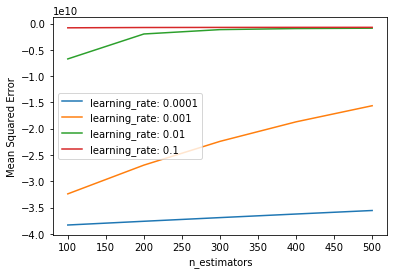

In [67]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')

In [68]:
%%time
boost = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)
boost = boost.fit(poly_matrix, train['SalePrice'])

CPU times: user 6min 50s, sys: 2.47 s, total: 6min 52s
Wall time: 6min 54s


In [69]:
train_preds = boost.predict(poly_matrix)

In [70]:
from sklearn.metrics import mean_squared_error
print mean_squared_error(train['SalePrice'], train_preds)**0.5

8591.9330349


In [71]:
test = test.fillna(-1)
test_matrix = dv.transform(test[cats].T.to_dict().values())
test_data_matrix = hstack([test_matrix, test[nums]])
test_poly = poly.transform(test_data_matrix.toarray())

In [72]:
preds = boost.predict(test_poly)

In [73]:
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = preds

In [74]:
submission.to_csv('submission_xgb.csv', index=False)